In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import asyncio
from scipy.spatial.distance import euclidean, pdist, cdist, squareform
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import preprocessing
from datetime import datetime
from dataclasses import make_dataclass
from server import models
from server import config
from server.learn import regenerate_heartbeats, HeartbeatsSimilarityBuffer

await models.init_db({ 'config': config })

In [2]:
device = await models.Device.get(name='Mi Smart Band 4')
rooms, scanners = await models.get_rooms_scanners()
tmp_buffer = HeartbeatsSimilarityBuffer(scanners)
await asyncio.gather(*[regenerate_heartbeats(device, r, tmp_buffer) for r in rooms])
raw_signals = await models.DeviceHeartbeat.filter(device=device).prefetch_related('room')

In [3]:
Signal = make_dataclass('Signal',  [
    ("id", int),
    ("room", 'string'),
    ("room_id", int),
    ("office", float), 
    ("bathroom", float), 
    ("extra_1", float), 
    ("lobby", float), 
    ("laundry", float), 
    ("kitchen", float), 
    ("guest", float), 
    ("bedroom", float),
])

signals_df = pd.DataFrame([Signal(
    id=s.id,
    room=s.room.name,
    room_id=s.room.id,
    office=s.signals.get('office', {}).get('filtered_rssi', -100),
    bathroom=s.signals.get('bathroom', {}).get('filtered_rssi', -100),
    extra_1=s.signals.get('extra-1', {}).get('filtered_rssi', -100),
    lobby=s.signals.get('lobby', {}).get('filtered_rssi', -100),
    laundry=s.signals.get('laundry', {}).get('filtered_rssi', -100), 
    kitchen=s.signals.get('kitchen', {}).get('filtered_rssi', -100),
    guest=s.signals.get('guest', {}).get('filtered_rssi', -100),
    bedroom=s.signals.get('bedroom', {}).get('filtered_rssi', -100),
) for idx, s in enumerate(raw_signals)])

column_names_to_normalize = ['bathroom', 'office', 'extra_1', 'lobby', 'laundry', 'kitchen', 'guest', 'bedroom']
tmp_x = signals_df[column_names_to_normalize].values
tmp_x = (tmp_x - np.min(tmp_x))/(np.max(tmp_x) - np.min(tmp_x))
tmp_x_scaled = preprocessing.normalize(tmp_x, norm='l2')
df_temp = pd.DataFrame(tmp_x_scaled, columns=column_names_to_normalize, index = signals_df.index)
signals_df[column_names_to_normalize] = df_temp

signals_df.groupby('room').count()

,id,room_id,office,bathroom,extra_1,lobby,laundry,kitchen,guest,bedroom
room,,,,,,,,,,
Bathroom,13,13,13,13,13,13,13,13,13,13
Bedroom,23,23,23,23,23,23,23,23,23,23
Guest,55,55,55,55,55,55,55,55,55,55
Kitchen,56,56,56,56,56,56,56,56,56,56
Laundry,16,16,16,16,16,16,16,16,16,16
Lobby,32,32,32,32,32,32,32,32,32,32
Office,31,31,31,31,31,31,31,31,31,31


In [4]:
# tmp_x_filterd = [tmp_x_scaled[0]]
# tmp_x_indexes = [0]
# tmp_x_removed = []

# for i, s in enumerate(tmp_x_scaled):
#     distances = cdist(tmp_x_filterd, [s], 'euclidean')
#     close_signals = [i for i, d in enumerate(distances) if d < 0.1]
#     identical_signals = [i for i, d in enumerate(distances) if d < 0.001]

#     if len(close_signals) < 1 and len(identical_signals) == 0:
#         tmp_x_filterd.append(s)
#         tmp_x_indexes.append(i)
#     else:
#         tmp_x_removed.append(i)

# print('Original length: {}'.format(len(tmp_x_scaled)))
# print('New length: {}'.format(len(tmp_x_filterd)))

# removed_signals_df = signals_df.iloc[tmp_x_removed, :]
# signals_df = signals_df.iloc[tmp_x_indexes, :]

In [5]:
# ids = removed_signals_df['id'].values
# await models.DeviceHeartbeat.filter(id__in=ids).delete()

<AxesSubplot:>

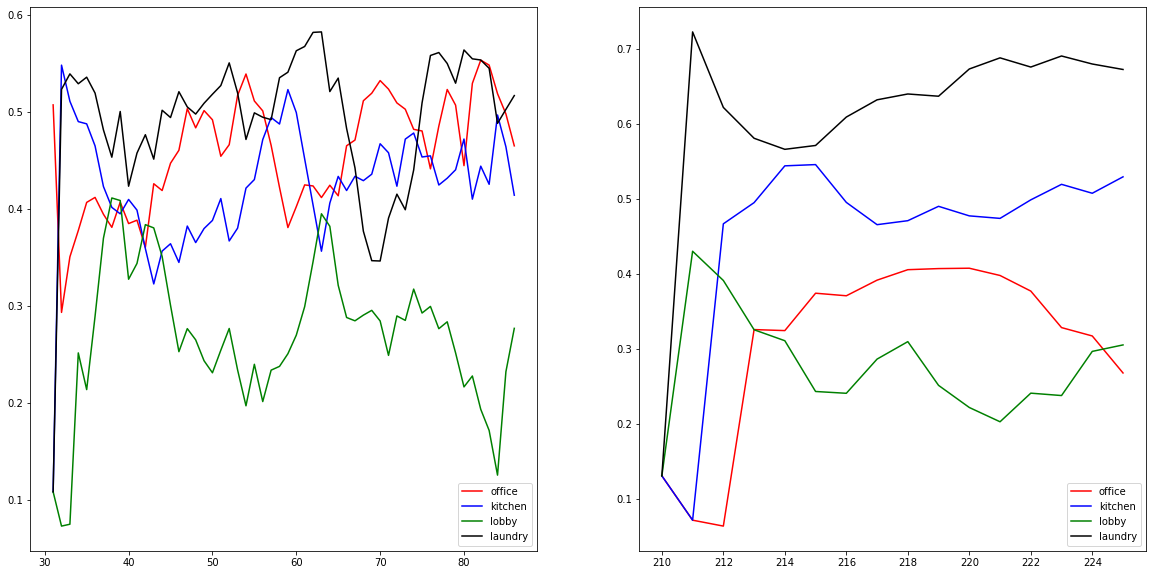

In [6]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121)
room_name = 'Kitchen'
signals_df[(signals_df['room']==room_name)].plot(y='office', color='red', ax=ax)
signals_df[(signals_df['room']==room_name)].plot(y='kitchen', color='blue', ax=ax)
signals_df[(signals_df['room']==room_name)].plot(y='lobby', color='green', ax=ax)
signals_df[(signals_df['room']==room_name)].plot(y='laundry', color='black', ax=ax)

ax = fig.add_subplot(122)
room_name = 'Laundry'
signals_df[(signals_df['room']==room_name)].plot(y='office', color='red', ax=ax)
signals_df[(signals_df['room']==room_name)].plot(y='kitchen', color='blue', ax=ax)
signals_df[(signals_df['room']==room_name)].plot(y='lobby', color='green', ax=ax)
signals_df[(signals_df['room']==room_name)].plot(y='laundry', color='black', ax=ax)


In [7]:
numbers_df = signals_df[column_names_to_normalize]
dists = pdist(numbers_df, 'euclidean')
euclid_df = pd.DataFrame(squareform(dists), columns=numbers_df.index, index=numbers_df.index)

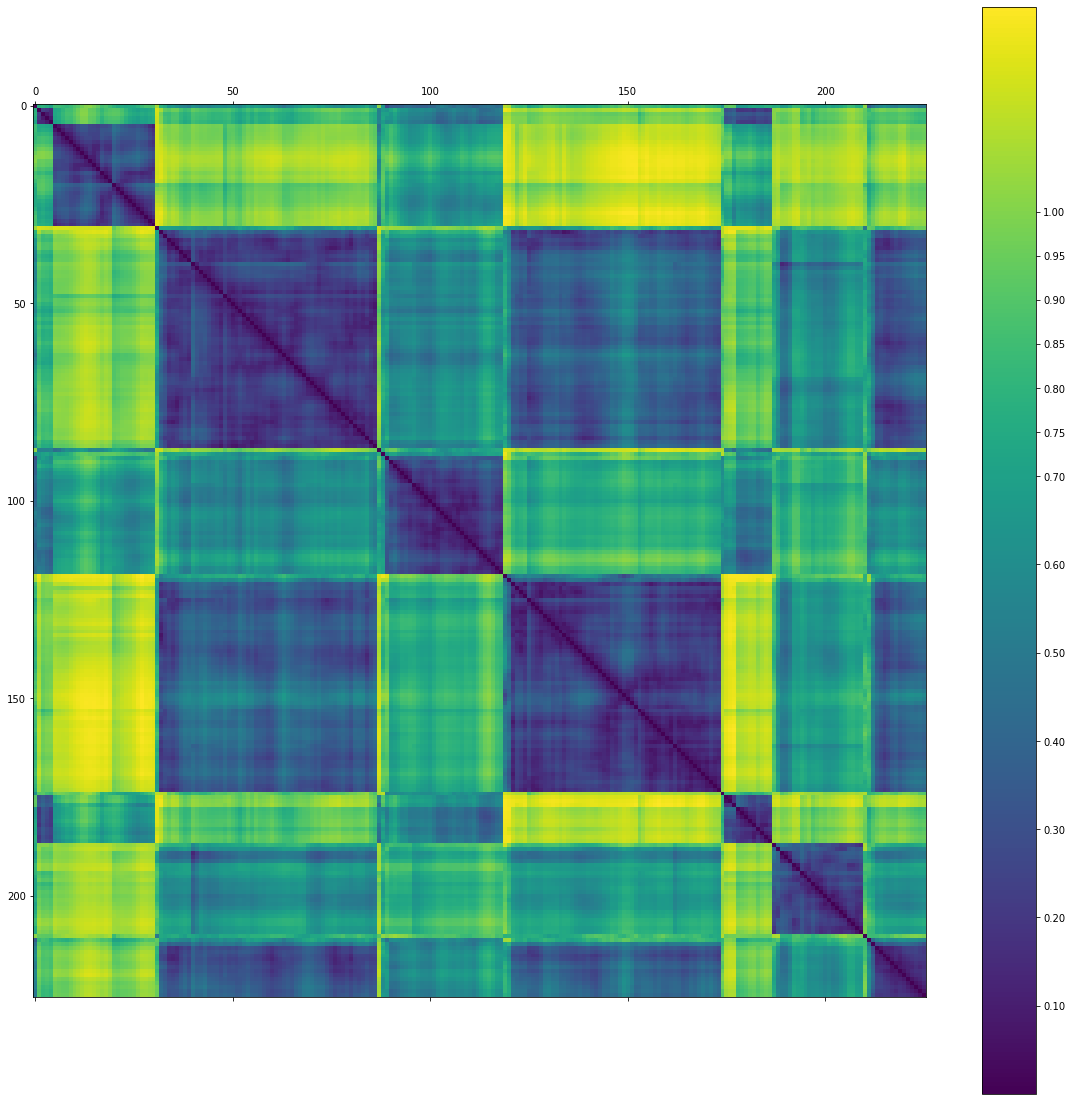

In [8]:
fig, ax = plt.subplots(figsize=(20,20))
cax = ax.matshow(euclid_df, interpolation='nearest')
fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])
plt.show()

100.0


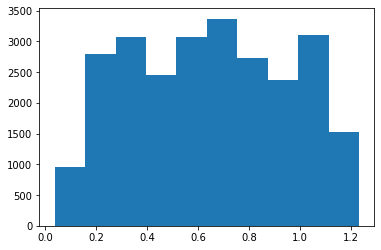

In [9]:
similarity_cut = dists[dists < 2]
plt.hist(similarity_cut)
print((len(similarity_cut) / len(dists)) * 100)

In [10]:
classifiers = {
    "Nearest Neighbors": KNeighborsClassifier(5),
    "Linear SVM": SVC(kernel="linear", C=0.025, probability=True),
    "RBF SVM": SVC(gamma=2, C=1, probability=True),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1),
    "Neural Net": MLPClassifier(alpha=1, max_iter=1000),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis()
}

X_train = signals_df[column_names_to_normalize].values
y_train = signals_df['room_id'].values

for name, classifier in classifiers.items():
    algo = classifier.fit(X_train, y_train)
    train_score = algo.score(X_train, y_train)
    print('{} score {}'.format(name, train_score))

Nearest Neighbors score 0.9690265486725663
Linear SVM score 0.24778761061946902
RBF SVM score 0.9424778761061947
Decision Tree score 0.9247787610619469
Random Forest score 0.9778761061946902
Neural Net score 0.8362831858407079
AdaBoost score 0.5752212389380531
Naive Bayes score 0.9646017699115044
QDA score 0.9646017699115044


/home/artem/development/blackhole/mqtt-room-presence/.venv/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [11]:
for r1 in rooms:
    for r2 in rooms:
        r1_signals = signals_df[column_names_to_normalize][signals_df['room_id']==r1.id].values
        r2_signals = signals_df[column_names_to_normalize][signals_df['room_id']==r2.id].values
        room_dists = cdist(r1_signals, r2_signals, 'euclidean')
        print('{} / {}: mean {}, std {}, min {}, max {}'.format(r1.name, r2.name, np.mean(room_dists), np.std(room_dists), np.min(room_dists), np.max(room_dists)))

Office / Office: mean 0.4082253818004636, std 0.2854479570740513, min 0.0, max 1.0125753926964758
Office / Kitchen: mean 0.9816035940260943, std 0.11233122974538662, min 0.47644846369079125, max 1.1918987565984875
Office / Lobby: mean 0.6638293608436503, std 0.12720370005553971, min 0.2693562640265415, max 1.019575375505369
Office / Guest: mean 1.0995840352719841, std 0.08896934400172544, min 0.7005138647974293, max 1.232306364859687
Office / Bathroom: mean 0.6929549572379946, std 0.1898873995023315, min 0.17406269109457473, max 1.0471388673670685
Office / Bedroom: mean 1.035869173241487, std 0.08022615677656113, min 0.6599849868241621, max 1.1505928916943255
Office / Laundry: mean 0.9799732973413173, std 0.11720083463572886, min 0.35662150721320834, max 1.1664548081091126
Kitchen / Office: mean 0.9816035940260942, std 0.11233122974538663, min 0.47644846369079125, max 1.1918987565984875
Kitchen / Kitchen: mean 0.23124208631083362, std 0.1162085655459376, min 0.0, max 0.7761839039411333